# Failed Banks ML Project

## Econ 1680: MLTA and Econ

#### Name: Lena Kim

Bank failure is often a harbinger of economic crises, as people look towards the status of
banks as a symbol of financial health. Classic economic literature has countlessly used banks’
financial statements and ratios to develop regression models that can predict a bank’s even-
tual closure (Meyer and Pifer (1970)). Such research has indicated liquidity ratios, rates of
interest, and operating revenue as the most salient metrics in determining whether a bank
fails.

For this project, I seek to go beyond the prediction of bank failures and consider what
happens after that failure. Using the failed bank’s balance sheet metrics, I hope to predict
whether it is eventually acquired by a larger national bank, a regional bank, or not acquired
at all. I will consider grouping by time, as the 2008 financial crisis will have significantly
played a hand in these results. In doing so, I will identify which balance sheet metrics play
the most significant role in this result, and compare these outcomes with the classic findings
and metrics defined previously.

Research Question: Given a failed bank’s balance sheet metrics, how can we predict
whether it is acquired by a national bank, a regional bank, or not acquired at all? Which
metrics contribute the most weight to this decision?

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer



In [292]:
#some minor, inconsequential future warnings were getting in the way, so removed as last step:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category= RuntimeWarning) 

In [263]:
balance_sheets = pd.read_csv('data/BalanceSheetSummaries.xls.csv')
acquisitions = pd.read_csv('data/banklist.csv', encoding='latin-1')


In [264]:
acquisitions.head()

,Bank Name,City,State,Cert,Acquiring Institution,Closing Date,Fund
0,First Republic Bank,San Francisco,CA,59017,"JPMorgan Chase Bank, N.A.",1-May-23,10543
1,Signature Bank,New York,NY,57053,"Flagstar Bank, N.A.",12-Mar-23,10540
2,Silicon Valley Bank,Santa Clara,CA,24735,FirstCitizens Bank & Trust Company,10-Mar-23,10539
3,Almena State Bank,Almena,KS,15426,Equity Bank,23-Oct-20,10538
4,First City Bank of Florida,Fort Walton Beach,FL,16748,"United Fidelity Bank, fsb",16-Oct-20,10537


In [265]:
#Data cleanup:
#Clean "failure date" to convert all types into datetime
balance_sheets['Failure Date'] = pd.to_datetime(balance_sheets['Failure Date'], format= '%m/%d/%Y', errors = 'coerce').combine_first(
    pd.to_datetime(balance_sheets['Failure Date'], format='%m-%d-%Y', errors='coerce')
) 

#Clean "Receivership column" into lowercase 
balance_sheets['Bank Name'] = balance_sheets['Receivership'].str.lower()
balance_sheets['Receivership'] = balance_sheets['Bank Name']
balance_sheets.head()

#Strip whitespaces of columns in acquisitions:
acquisitions.columns = acquisitions.columns.str.strip()
acquisitions['Bank Name'] = acquisitions['Bank Name'].str.lower()

#do a join to combine the two based on 'Receivership' column of balance_sheets and 'Bank Name' of acquisitions:
banks = balance_sheets.merge(acquisitions, left_on='Receivership', right_on='Bank Name', how='left')
#Get rid of repeated info: 
banks = banks.drop(columns=['Bank Name_x', 'Bank Name_y', 'Year']) #Year means "as of 2023", which is why all values are 2023. drop this. 

#Call head to ensure cleanliness:
banks.head(10)


,Fund Code,Receivership,Quarter,Failure Date,Cash and Investments,Due from FDIC Corp and Receivables,Assets in Liquidation,Estimated Loss on Assets in Liquidation(1),Total Assets,Administrative Liabilities,...,Dividends Paid to Date - Other Claimants,Dividends Paid to Date - Other Claimants %,Total Unpaid Other Claimants,Total Unpaid Other Claimants %,City,State,Cert,Acquiring Institution,Closing Date,Fund
0,10538,almena state bank,Q1,2020-10-23,2785.0,0.0,0.0,0.0,2785.0,0.0,...,0.0,0.0,338.0,100.0,Almena,KS,15426.0,Equity Bank,23-Oct-20,10538.0
1,10218,"amcore bank, na",Q1,2010-04-23,13944.0,0.0,0.0,0.0,13944.0,5350.0,...,0.0,0.0,57986.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10057,america west bank,Q1,2009-05-01,1006.0,0.0,0.0,0.0,1006.0,1.0,...,0.0,0.0,1097.0,100.0,Layton,UT,35461.0,Cache Valley Bank,1-May-09,10057.0
3,10053,american southern bank,Q1,2009-04-24,2456.0,0.0,0.0,0.0,2456.0,0.0,...,0.0,0.0,232.0,100.0,Kennesaw,GA,57943.0,Bank of North Georgia,24-Apr-09,10053.0
4,10155,amtrust bank,Q1,2009-12-04,14112.0,0.0,0.0,0.0,14112.0,5352.0,...,0.0,0.0,25727.0,100.0,Cleveland,OH,29776.0,New York Community Bank,4-Dec-09,10155.0
5,10369,atlantic bank & trust,Q1,2011-06-03,1018.0,0.0,0.0,0.0,1018.0,0.0,...,0.0,0.0,33.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
6,10380,bank of choice,Q1,2011-07-22,1144.0,0.0,0.0,0.0,1144.0,1.0,...,0.0,0.0,860.0,100.0,Greeley,CO,2994.0,"Bank Midwest, N.A.",22-Jul-11,10380.0
7,10029,bank of clark county,Q1,2009-01-16,2520.0,0.0,0.0,0.0,2520.0,72.0,...,0.0,0.0,779.0,100.0,Vancouver,WA,34959.0,Umpqua Bank,16-Jan-09,10029.0
8,10064,bank of lincolnwood,Q1,2009-06-05,3013.0,0.0,0.0,0.0,3013.0,0.0,...,0.0,0.0,513.0,100.0,Lincolnwood,IL,17309.0,Republic Bank of Chicago,5-Jun-09,10064.0
9,10396,bank of the commonwealth,Q1,2011-09-23,5166.0,0.0,0.0,0.0,5166.0,9.0,...,0.0,0.0,1673.0,100.0,Norfolk,VA,20408.0,Southern Bank and Trust Company,23-Sep-11,10396.0


# EDA

In [266]:
#Total Assets:
banks.describe()


,Failure Date,Cash and Investments,Due from FDIC Corp and Receivables,Assets in Liquidation,Estimated Loss on Assets in Liquidation(1),Total Assets,Administrative Liabilities,FDIC Subrogated Deposit Claim,Uninsured Deposit Claims,Other Claimant Liabilities,...,Subordinated Debt Holders,Subordinated Debt Holders %,Subtotal- Other Claimants,Subtotal- Other Claimants %,Dividends Paid to Date - Other Claimants,Dividends Paid to Date - Other Claimants %,Total Unpaid Other Claimants,Total Unpaid Other Claimants %,Cert,Fund
count,126,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,1.260000e+02,126.000000,1.260000e+02,...,1.260000e+02,126.000000,1.260000e+02,126.0,1.260000e+02,126.000000,1.260000e+02,126.000000,102.000000,102.000000
mean,2011-04-24 14:17:08.571428608,7209.111111,-1.047619,281.960317,-103.079365,7386.944444,1006.515873,3.011899e+05,924.309524,1.298284e+05,...,7.082021e+04,6.698413,1.485982e+05,100.0,1.876975e+04,4.063492,1.298284e+05,95.936508,31306.480392,10250.000000
min,2008-07-11 00:00:00,80.000000,-78.000000,0.000000,-3909.000000,80.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000,1.400000e+01,100.0,0.000000e+00,0.000000,0.000000e+00,0.000000,1006.000000,10008.000000
25%,2009-08-15 18:00:00,1257.500000,0.000000,0.000000,0.000000,1274.000000,0.000000,3.771725e+04,0.000000,3.770000e+02,...,0.000000e+00,0.000000,4.415000e+02,100.0,0.000000e+00,0.000000,3.770000e+02,100.000000,22310.500000,10101.500000
50%,2010-07-02 00:00:00,2469.000000,0.000000,0.000000,0.000000,2554.000000,2.000000,7.473300e+04,0.000000,9.085000e+02,...,0.000000e+00,0.000000,1.110000e+03,100.0,0.000000e+00,0.000000,9.085000e+02,100.000000,32279.000000,10240.500000
75%,2011-11-03 06:00:00,5383.250000,0.000000,0.000000,0.000000,5383.250000,64.250000,2.098012e+05,0.000000,6.458500e+03,...,0.000000e+00,0.000000,6.543000e+03,100.0,0.000000e+00,0.000000,6.458500e+03,100.000000,35368.000000,10395.000000
max,2020-10-23 00:00:00,153977.000000,72.000000,13001.000000,0.000000,153977.000000,24452.000000,1.209765e+07,94350.000000,1.480867e+07,...,7.723052e+06,96.000000,1.682582e+07,100.0,2.017154e+06,100.000000,1.480867e+07,100.000000,58429.000000,10538.000000
std,NaN,18748.560664,12.042496,1415.601534,473.364614,18979.448777,2824.179560,1.121916e+06,8448.841580,1.319010e+06,...,6.889500e+05,21.996461,1.498643e+06,0.0,1.819750e+05,19.608874,1.319010e+06,19.608874,14461.601289,163.515161


Text(0.5, 1.0, 'Bank Failures by Year')

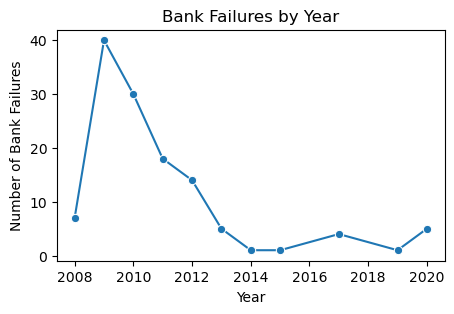

In [267]:
#Number of bank failures by year:
banks['Year'] = banks['Failure Date'].apply(lambda x: x.year)
bank_fails_by_year = banks['Year'].value_counts().sort_index()
#print(bank_fails_by_year)

#plot it:
plt.figure(figsize=(5, 3))
sns.lineplot(x=bank_fails_by_year.index, y=bank_fails_by_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Bank Failures')
plt.title('Bank Failures by Year')

Text(0.5, 1.0, 'Bank Failures by City')

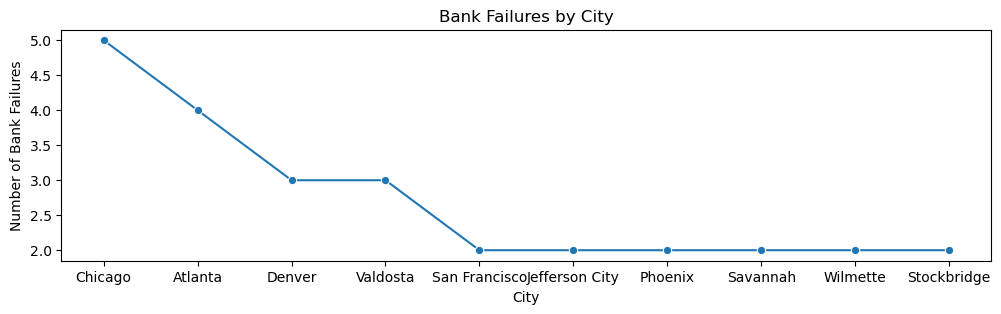

In [268]:
#Does location matter?: Top cities with bank failures
failures_by_city = banks['City'].value_counts().head(10)

#plot it:
plt.figure(figsize=(12, 3))
sns.lineplot(x=failures_by_city.index, y=failures_by_city.values, marker='o')
plt.xlabel('City')
plt.ylabel('Number of Bank Failures')
plt.title('Bank Failures by City')




Text(0.5, 1.0, 'Top Acquiring Institution of Failure Banks')

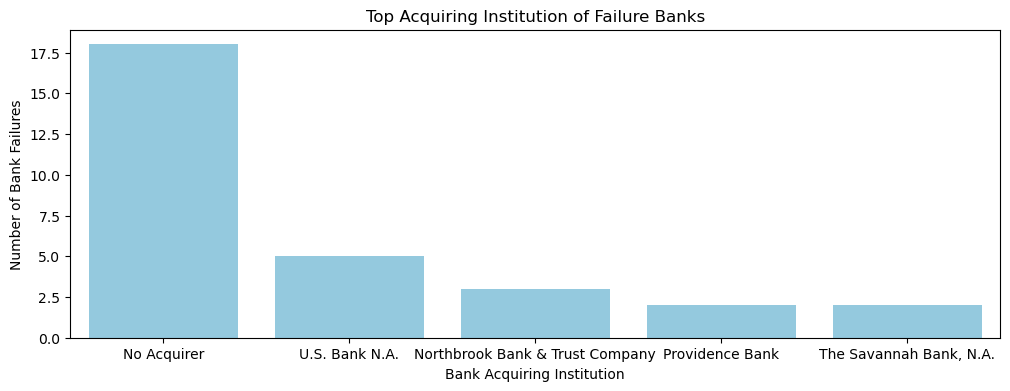

In [269]:
#Top acquirers:
bank_acq = banks['Acquiring Institution'].value_counts().head(5)
plt.figure(figsize=(12, 4))
sns.barplot(x=bank_acq.index, y=bank_acq.values, color='skyblue')
plt.xlabel('Bank Acquiring Institution')
plt.ylabel('Number of Bank Failures')
plt.title('Top Acquiring Institution of Failure Banks')

In [270]:
#How much funds left before default?
top_banks_by_fund = banks.sort_values('Fund', ascending=False).head(5)
top_banks_by_fund[['Receivership', 'Failure Date', 'City', 'State', 'Fund']]

,Receivership,Failure Date,City,State,Fund
0,almena state bank,2020-10-23,Almena,KS,10538.0
109,the first state bank,2020-04-03,Barboursville,WV,10536.0
36,ericson state bank,2020-02-14,Ericson,NE,10535.0
50,first nbc bank,2017-04-28,New Orleans,LA,10526.0
92,proficio bank,2017-03-03,Cottonwood Heights,UT,10525.0


# Prep for ML

Here, I will add another column to my dataframe using "0" for not acquired/NA/nan, "1" for acquired by regional bank, and "2" for national bank

In [271]:
regional_banks = ['Cache Valley Bank', 'Bank of North Georgia', 'Columbia State Bank', 'North Jersey Community Bank', 'Morton Community Bank', 
'Century Bank of Georgia', 'CB&S Bank, Inc','Blackhawk Bank & Trust', 'Polonia Bank', 'Farmers and Merchants Bank', 'First Michigan Bank', 
'Northbrook Bank & Trust Company', 'The Savannah Bank, N.A.', 'The Jefferson Bank', 'Mutual of Omaha Bank', 'Whitney Bank', 'Metro City Bank',
'SmartBank', 'City National Bank', 'Stonegate Bank', 'Level One Bank', 'Ameris Bank', 'International Bank of Chicago', 'Providence Bank', 
'Nevada State Bank', 'First Federal Bank of Florida', 'Heritage Bank', 'MVB Bank, Inc.', 'Hamilton State Bank', 
'Bank 7', 'Kitsap Bank', 'Wheaton Bank & Trust'] #Manually classified as regional after research

national_banks = ['Equity Bank', 'New York Community Bank', 'Bank Midwest, N.A. ', 'Umpqua Bank', 'Republic Bank of Chicago', 'Southern Bank and Trust Company',
'U.S. Bank N.A.', 'MidFirst Bank', 'Banco Popular de Puerto Rico', 'Sadabell United Bank, N.A.', 'Manufacturers and Traders Trust Company (M&T Bank)',
'CenterState Bank of Florida, N.A.', 'First-Citizens Bank & Trust Company', 'United Fidelity Bank, fsb', 'First Merchants Bank, National Association', 
'Citizens Bank', 'Synovus Bank', 'Superior Bank, National Association', 'Union Bank, N.A.', 'Bank of the Ozarks', 'Valley National Bank', 
'East West Bank', 'Huntington National Bank']
#Manually classified as national after research

#Make new column, Acquisition Type, which will be our main target variable of interest:
banks['Acquisition Type'] = banks['Acquiring Institution'].apply(lambda x: 
                              0 if pd.isna(x) else 
                              1 if x in regional_banks else 
                              2 if x in national_banks else 
                              0)


In [272]:
#Train Test Split and Scaling Features:
banks['Total Liabilities'] = banks['Total Assets'] - banks['Net Worth (Deficit)'] #make total liabilities column from info already there

selected_columns = ['Cash and Investments', 'Due from FDIC Corp and Receivables', 'Assets in Liquidation', 'Total Assets', 
                    'Administrative Liabilities', 'Total Unpaid Other Claimants', 'Uninsured Deposit Claims',
                    'General Creditor', 'Total Liabilities',
                    'Acquisition Type'] #These are most important columns that are not basically repeated info
banks_relevant = banks[selected_columns]

X = banks_relevant.drop('Acquisition Type', axis=1) #features: everything except target
y = banks_relevant['Acquisition Type'] #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1680)





In [273]:
#Checking dimensions of model to prevent bugs later on:
m_train = X_train.shape[0]
m_test =  X_test.shape[0]
num_features = X_train.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Number of features for each observation = " + str(num_features))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: m_train = 103
Number of testing examples: m_test = 26
Number of features for each observation = 9
X_train shape: (103, 9)
y_train shape: (103,)
X_test shape: (26, 9)
y_test shape: (26,)


# But this is a small number for testing. Solution?

Solution: 

K-Fold split. I leverage K-Fold splitting and cross validation to ensure that the model can be as robust as possible. 

Deciding on K = 5 (seems to be industry norm based on research, I will divide my dataset into 5 subsets (folds), train the model 5 times, each time using a different fold as the testing set and the remaining data as the training set. This solves my concern.

In [274]:
# Set upKfolds:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1680)


# Models

Although we have spent a considerable amount of time in class on OLS, Lasso, and Ridge regressions, I decided against using these models because my question is a classification problem, not a straightforward continuous/linear application like these mentioned models assume. 

The rest of the notebook focuses on the models I have chosen:


In [278]:
#Preprocess the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Fixes found when running the models:
#jupyter suggested to impute NaN features. After doing that:
imputer = SimpleImputer(strategy='mean')

#Fit the imputer:
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)



In [293]:
#First, Multinomial Logit Regressions (since these are tricategories of 0, 1, and 2):
mnlogit_res = sm.MNLogit(y_train, X_train).fit()

mnlogit_res.summary() , 
#positive significance= if a bank has higher admin liabs than type 0 bank, it positively predicts whether it gets acquired by national bank
#compare to mean value of admin liabilities -> x % increase from mean of liabilities in sample, you have 0.007 increase in prob of acquisition
#"Marginal effects"

Optimization terminated successfully.
         Current function value: nan
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:       Acquisition Type   No. Observations:                  103
Model:                        MNLogit   Df Residuals:                       85
Method:                           MLE   Df Model:                           16
Date:                Wed, 06 Mar 2024   Pseudo R-squ.:                     nan
Time:                        15:12:08   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -107.28
Covariance Type:            nonrobust   LLR p-value:                       nan
======================================================================================================
                Acquisition Type=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Cash and Investments                  -0.0015      0.006     -0.274      0.784      -0.013       0.009
Due from FDIC Corp and Receivables    -0.0036      0.026     -0.137      0.891      -0.055       0.048
Assets in Liquidation                 -0.0006      0.004     -0.166      0.868      -0.008       0.007
Total Assets                           0.0016      0.006      0.276      0.783      -0.009       0.013
Administrative Liabilities          3.338e-05      0.000      0.114      0.909      -0.001       0.001
Total Unpaid Other Claimants          -0.0001   9.23e-05     -1.234      0.217      -0.000     6.7e-05
Uninsured Deposit Claims              -0.0003      0.000     -1.237      0.216      -0.001       0.000
General Creditor                   -9.756e-05      0.000     -0.788      0.431      -0.000       0.000
Total Liabilities                   1.835e-06    1.4e-06      1.308      0.191   -9.14e-07    4.59e-06
------------------------------------------------------------------------------------------------------
                Acquisition Type=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Cash and Investments                  -0.0157      0.008     -1.880      0.060      -0.032       0.001
Due from FDIC Corp and Receivables    -0.0778      0.059     -1.322      0.186      -0.193       0.038
Assets in Liquidation                 -0.0106      0.006     -1.786      0.074      -0.022       0.001
Total Assets                           0.0153      0.008      1.844      0.065      -0.001       0.032
Administrative Liabilities             0.0007      0.000      2.800      0.005       0.000       0.001
Total Unpaid Other Claimants       -5.261e-06   1.25e-05     -0.420      0.674   -2.98e-05    1.93e-05
Uninsured Deposit Claims               0.0001      0.000      0.742      0.458      -0.000       0.001
General Creditor                    1.263e-05   3.93e-05      0.321      0.748   -6.44e-05    8.97e-05
Total Liabilities                   5.231e-07   8.85e-07      0.591      0.554   -1.21e-06    2.26e-06
======================================================================================================
"""

In [294]:
#First, Multinomial Logit Regressions (since these are tricategories of 0, 1, and 2):
#Will do hyperparameter tuning and search for best model with it as well:

#Set up model
logit = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', solver='newton-cg'))

#parameter grid:
param_grid = {
    'logisticregression__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

#search for best one and fit it:
grid_search = GridSearchCV(logit, param_grid, cv=kf, scoring='accuracy') #here implement the kfolds
grid_search.fit(X_train, y_train)

print(f'Best Hyperparameters: {grid_search.best_params_}')
y_pred = grid_search.predict(X_test)

#accuracy scores (our eval metric):
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy}')

Best Hyperparameters: {'logisticregression__C': 1e-05}
Accuracy on Test Set: 0.38461538461538464


In [297]:
#Multilayer Perceptron:
#specifying a neural network with two hidden layers of 4 and 2 neurons. 
MLP = MLPClassifier(hidden_layer_sizes=(8,4),random_state=1680, activation='logistic', solver='adam', max_iter =500,
                    verbose=True, learning_rate_init=0.01) #creates a Multi-layer Perceptron (MLP) classifier.  
MLP.fit(X_train,y_train) 
print('MLP accuracy train:', accuracy_score(y_train,MLP.predict(X_train))) 
print('MLP accuracy test:',accuracy_score(y_test, MLP.predict(X_test)))

Iteration 1, loss = 1.13363944
Iteration 2, loss = 1.11868669
Iteration 3, loss = 1.10601981
Iteration 4, loss = 1.09475333
Iteration 5, loss = 1.08488888
Iteration 6, loss = 1.07640956
Iteration 7, loss = 1.06918398
Iteration 8, loss = 1.06268695
Iteration 9, loss = 1.05758446
Iteration 10, loss = 1.05337572
Iteration 11, loss = 1.04997502
Iteration 12, loss = 1.04730995
Iteration 13, loss = 1.04531495
Iteration 14, loss = 1.04392511
Iteration 15, loss = 1.04307078
Iteration 16, loss = 1.04267364
Iteration 17, loss = 1.04264484
Iteration 18, loss = 1.04288637
Iteration 19, loss = 1.04329577
Iteration 20, loss = 1.04377380
Iteration 21, loss = 1.04269558
Iteration 22, loss = 1.05146588
Iteration 23, loss = 1.04928217
Iteration 24, loss = 1.04936691
Iteration 25, loss = 1.04819261
Iteration 26, loss = 1.04696156
Iteration 27, loss = 1.04554996
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLP accuracy train: 0.49514563106796117
MLP accuracy te